Package Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Global Declarations

In [2]:
DATA = '../data/data.csv'
NEIGHBOURHOOD = []
ROOM_TYPE = []

Data Preprocessing

In [3]:
#read data from csv file
def read_data(file_name):
    data = pd.read_csv(file_name)
    return data 

In [4]:
def df_cleanup():
    
    df = pd.DataFrame(read_data(DATA))

    df = df.drop(df[df.availability_365 < 1].index)
    
    df = df.drop('license', axis=1)
    df = df.drop('last_review', axis=1)
    df = df.drop('reviews_per_month', axis=1)
    df = df.drop('calculated_host_listings_count', axis=1)
    df = df.drop('minimum_nights', axis=1)
    df = df.drop('number_of_reviews_ltm', axis=1)
    df = df.drop('name', axis=1)
    df = df.drop('host_name', axis=1)
    df = df.drop('availability_365', axis=1)

    df = df.replace('Studio', 0)
    df = df.replace('No rating', -1)
    df = df.replace('Not specified', -1)

    df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
    df['baths'] = pd.to_numeric(df['baths'], errors='coerce')

    df = df.replace('Manhattan', 1)
    df = df.replace('Queens', 2)
    df = df.replace('Staten Island', 3)
    df = df.replace('Brooklyn', 4)
    df = df.replace('Bronx', 5)

    for i in df['neighbourhood']:
        if i in NEIGHBOURHOOD:
            df = df.replace(i, NEIGHBOURHOOD.index(i))
        else:
            NEIGHBOURHOOD.append(i)
            df = df.replace(i, NEIGHBOURHOOD.index(i))
    
    room_type = []

    for i in df['room_type']:
        if i in ROOM_TYPE:
            df = df.replace(i, ROOM_TYPE.index(i))
        else:
            ROOM_TYPE.append(i)
            df = df.replace(i, ROOM_TYPE.index(i))

    df['neighbourhood_group'] = pd.to_numeric(df['neighbourhood_group'], errors='coerce')
    df['neighbourhood'] = pd.to_numeric(df['neighbourhood'], errors='coerce')
    df['room_type'] = pd.to_numeric(df['room_type'], errors='coerce')

    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    df = df[df['price'] <= 3000]

    return df


In [5]:
DF = df_cleanup()

/var/folders/rq/91x5rw3560s1y0v50f_7jmz00000gn/T/ipykernel_53384/4040091694.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('Bronx', 5)
/var/folders/rq/91x5rw3560s1y0v50f_7jmz00000gn/T/ipykernel_53384/4040091694.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(i, NEIGHBOURHOOD.index(i))
/var/folders/rq/91x5rw3560s1y0v50f_7jmz00000gn/T/ipykernel_53384/4040091694.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old be

Dataframe Visualization

In [6]:
print(DF.shape)
print(DF.dtypes)
print(ROOM_TYPE)
print(NEIGHBOURHOOD)
print(DF)

(18097, 13)
id                       int64
host_id                  int64
neighbourhood_group      int64
neighbourhood            int64
latitude               float64
longitude              float64
room_type                int64
price                  float64
number_of_reviews        int64
rating                 float64
bedrooms                 int64
beds                     int64
baths                  float64
dtype: object
['Entire home/apt', 'Private room', 'Hotel room', 'Shared room']
["Hell's Kitchen", 'Chelsea', 'Washington Heights', 'Murray Hill', 'Williamsburg', 'Sunset Park', 'Astoria', 'Financial District', 'Midtown', 'Upper West Side', 'Concourse Village', 'Flushing', 'Greenpoint', 'Cypress Hills', "Prince's Bay", 'Port Richmond', 'East Village', 'Clason Point', 'Bedford-Stuyvesant', 'Gravesend', 'Long Island City', 'Gramercy', 'East Flatbush', 'Kensington', 'St. George', 'South Ozone Park', 'Wakefield', 'Forest Hills', 'Springfield Gardens', 'North Riverdale', 'Belmont', 'C

In [7]:
#chech if there is entries with price > 3000
def check_price(df):
    if df[df['price'] > 3000].empty:
        print("No entries with price > 3000")
    else:
        print("There are entries with price > 3000")
        print(df[df['price'] > 3000])

check_price(DF)

No entries with price > 3000


Correlation Matrix

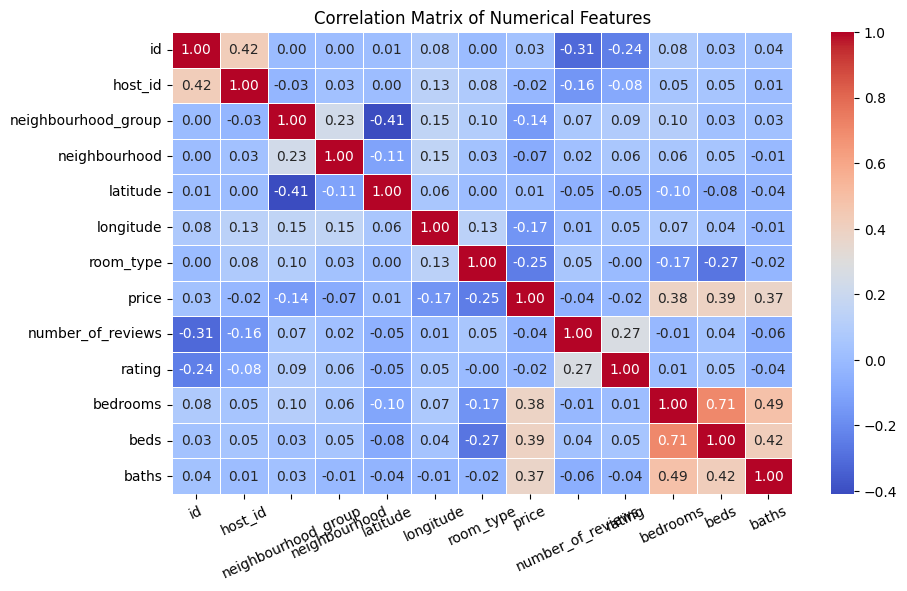

In [8]:
numerical_columns = DF.select_dtypes(include='number')
correlation_matrix = numerical_columns.corr()
# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.xticks(rotation = 25)
plt.show()

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220]


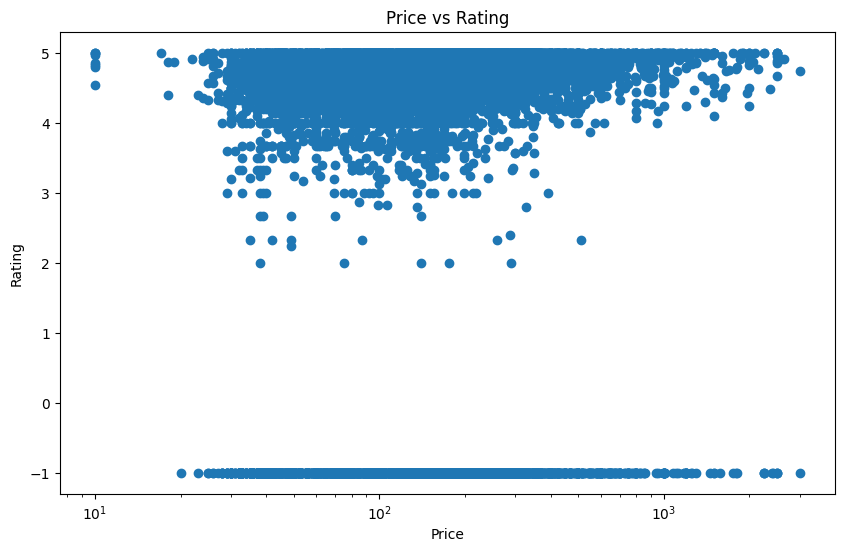

In [9]:
# create list with uniques neighborhood names, where the each index is the unique name
unique = DF['neighbourhood'].unique()
print(unique)

#scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(DF['price'], DF['rating'])
plt.title('Price vs Rating')
#make x label log scale
plt.xscale('log')
plt.xlabel('Price')
plt.ylabel('Rating')
plt.show()